# Train model using a single level image

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import time

from PIL import Image
from sklearn.model_selection import train_test_split
import IPython.display as display


import tensorflow as tf
import pandas as pd

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, concatenate, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential

## Generate Data Pipeline

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 299
SHUFFLE_SIZE = 1000
BUFFER_SIZE = 1000

In [ ]:
# connect to google drive
from google.colab import drive 
drive.mount('/content/gdrive/',force_remount=True) 

Mounted at /content/gdrive/


In [ ]:
import glob
train_data = glob.glob("/content/gdrive/MyDrive/patches2/level_0_img/*.png")

In [ ]:
os.chdir("/content/gdrive/MyDrive/adl_project")

In [ ]:
print(f'we have {len(train_data)} samples')

we have 6946 samples


In [ ]:
train_data[:5]

['/content/gdrive/MyDrive/patches2/level_0_img/normal_tumor_096_132_155_0.png',
 '/content/gdrive/MyDrive/patches2/level_0_img/normal_tumor_096_147_155_0.png',
 '/content/gdrive/MyDrive/patches2/level_0_img/normal_tumor_096_277_155_0.png',
 '/content/gdrive/MyDrive/patches2/level_0_img/normal_tumor_096_280_155_0.png',
 '/content/gdrive/MyDrive/patches2/level_0_img/normal_tumor_096_34_156_0.png']

In [ ]:
all_image_paths = [str(path) for path in train_data]
image_count = len(all_image_paths)
image_count

6946

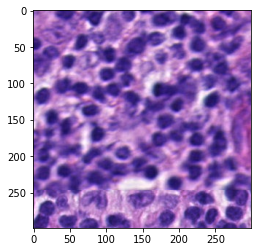

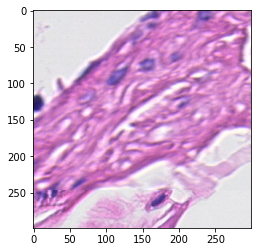

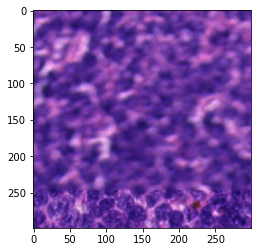

In [ ]:
# display some samples
for i in range(3):
  j = random.randint(0,len(all_image_paths)-1)
  img = all_image_paths[i]
  img = img.strip()
  imgplot = plt.imshow(mpimg.imread(img))
  plt.show()

In [ ]:
all_labels = [0]*len(all_image_paths)
for i in range(len(all_image_paths)):
  if 'normal' not in all_image_paths[i]:
    all_labels[i] = 1
print(len(all_labels),sum(all_labels))

6946 3473


### Create a feature extraction model based on InceptionV3

In [ ]:
# Create a feature extraction model based on InceptionV3
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
activations_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
# A method to load an image off disk and preprocess it appropriately for the model above.
def preprocess_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [ ]:
# This cell will extract activations for each image and save them to disk in NumPy format. 

# # Create a dataset to load each image off disk, and extract activations
# image_dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)
# image_dataset = image_dataset.map(
#   preprocess_img, 
#   num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
# # print(image_dataset[1])

# # Loop over the datset, and save all activations to disk in NumPy format
# for img_batch, path_batch in image_dataset:
#   batch_features = activations_model(img_batch)
#   for bf, p in zip(batch_features, path_batch):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())  

In [ ]:
def load_np(img_path, label):
  activations = np.load(img_path.decode('utf-8')+'.npy')
  return activations, label, img_path

In [ ]:
# This method will create a dataset that returns four elements.
# - a batch of activations (loaded from disk)
# - a batch of labels
# - a batch of absolute paths to the corresponding images
def create_dataset(images, labels):
  dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                labels))
  dataset = dataset.map(lambda x, y: tf.numpy_function(
      load_np, [x, y], [tf.float32, tf.int32, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

### Create train and validation (test) set

In [ ]:
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)  

In [ ]:
print(len(train_paths))
print(len(train_labels))
print(len(test_paths))
print(len(test_labels))
print(f'positive training samples {sum(train_labels)}, negative training samples {len(train_labels)-sum(train_labels)}')
print(f'positive test samples {sum(test_labels)}, negative test samples {len(test_labels)-sum(test_labels)}')

5209
5209
1737
1737
positive training samples 2635, negative training samples 2574
positive test samples 838, negative test samples 899


In [ ]:
train_ds = create_dataset(train_paths,train_labels)

In [ ]:
val_ds = create_dataset(test_paths,test_labels)

In [ ]:
my_iterator = iter(train_ds)
activations_batch, answers_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      answers_batch.shape, 
      paths_batch.shape)

(32, 8, 8, 2048) (32,) (32,)


In [ ]:
answers_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)>

## Design a model with transfer learning

In [ ]:
image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
vision_model.add(Flatten())

# Output of your vision model
encoded_image = vision_model(image_input) 

# model = tf.keras.Sequential([
#           image_model,
#           tf.keras.layers.Flatten(),
#           tf.keras.layers.Dense(256, activation='relu'),
#           tf.keras.layers.Dropout(.5),
#           tf.keras.layers.Dense(1, activation='sigmoid')
#           ])
dense1 =  Dense(256, activation='relu')(encoded_image)
drop1 = Dropout(.4)(dense1)
dense2 =  Dense(128, activation='relu')(drop1)
drop2 = Dropout(.4)(dense2)
output = Dense(1, activation='sigmoid')(drop2)

# Your final model
model = Model(inputs=image_input, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8, 8, 2048)]      0         
                                                                 
 sequential_3 (Sequential)   (None, 131072)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 129 

In [ ]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

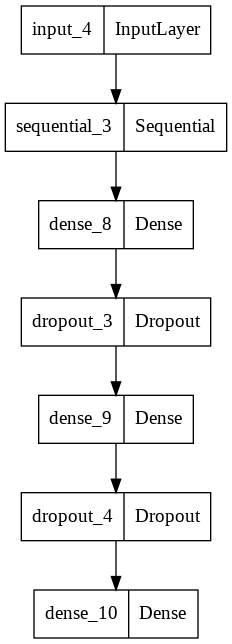

In [ ]:
# plot my model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Fit model on a single batch

In [ ]:
loss =[]
accuracy = []
for i in range(120):
  metrics = model.train_on_batch(x=activations_batch, y=answers_batch)
  loss.append(metrics[0])
  accuracy.append(metrics[1])

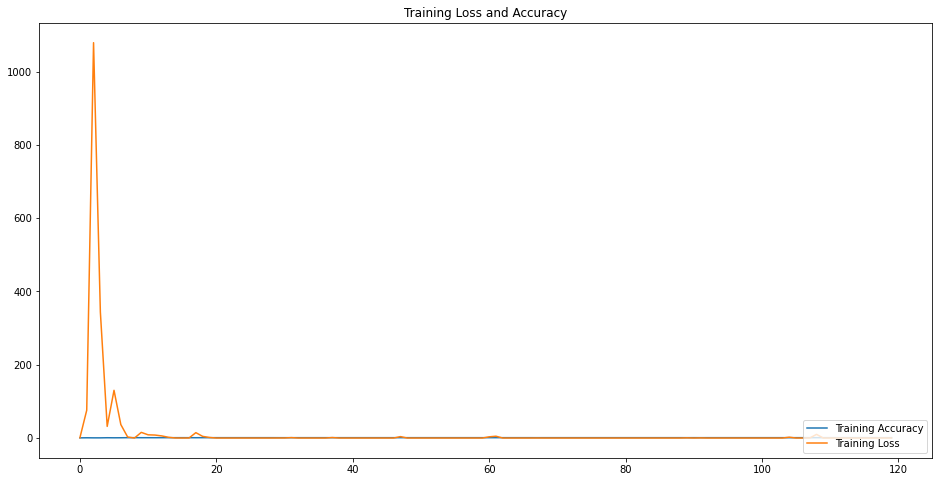

In [ ]:
epochs_range = range(120)

plt.figure(figsize=(16, 8))
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='lower right')
plt.title('Training Loss and Accuracy');

In [ ]:
metrics[0]

1.4716133678368001e-31

### Train model on the whole set

In [ ]:
drive_root = '/drive/MyDrive/adl_project'

# This code will save checkpoints in drive.
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "project")

# Used for formatting
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}-{model}.ckpt")

In [ ]:
# Restore the latest checkpoint (if it exists).
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from /drive/MyDrive/adl_project/checkpoints/project/cp-00000009-InceptionV3.ckpt


In [ ]:
# Utilities to help us record metrics.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

In [ ]:
# Code to evaluate on the validation dataset
def evaluate(ds, max_steps=None):
  steps = 0
  for activation_batch, answer_batch, path_batch in ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)

In [ ]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for activation_batch, answer_batch, path_batch in train_ds:
    result = model.train_on_batch(x=activation_batch, y=answer_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate(val_ds, max_steps=500)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  print("Saving weights")
  model.save_weights(checkpoint_path.format(epoch=epoch,model='InceptionV3'))

1/1 [==============================] - 0s 106ms/step
Epoch 0, Loss: 18.20, Accuracy: 72.62, Val Loss 0.43, Val Accuracy 79.62, Time: 56.9 secs
Saving weights
1/1 [==============================] - 0s 47ms/step
Epoch 1, Loss: 0.52, Accuracy: 78.47, Val Loss 0.34, Val Accuracy 85.20, Time: 50.4 secs
Saving weights
1/1 [==============================] - 0s 48ms/step
Epoch 2, Loss: 0.45, Accuracy: 83.13, Val Loss 0.31, Val Accuracy 88.08, Time: 55.5 secs
Saving weights
1/1 [==============================] - 0s 76ms/step
Epoch 3, Loss: 0.39, Accuracy: 84.50, Val Loss 0.35, Val Accuracy 83.82, Time: 61.5 secs
Saving weights
1/1 [==============================] - 0s 44ms/step
Epoch 4, Loss: 0.32, Accuracy: 87.52, Val Loss 0.26, Val Accuracy 90.04, Time: 54.5 secs
Saving weights
1/1 [==============================] - 0s 61ms/step
Epoch 5, Loss: 0.33, Accuracy: 88.15, Val Loss 0.24, Val Accuracy 90.73, Time: 53.2 secs
Saving weights
1/1 [==============================] - 0s 68ms/step
Epoch 6, L

### Plots of training and validation loss and accuracy

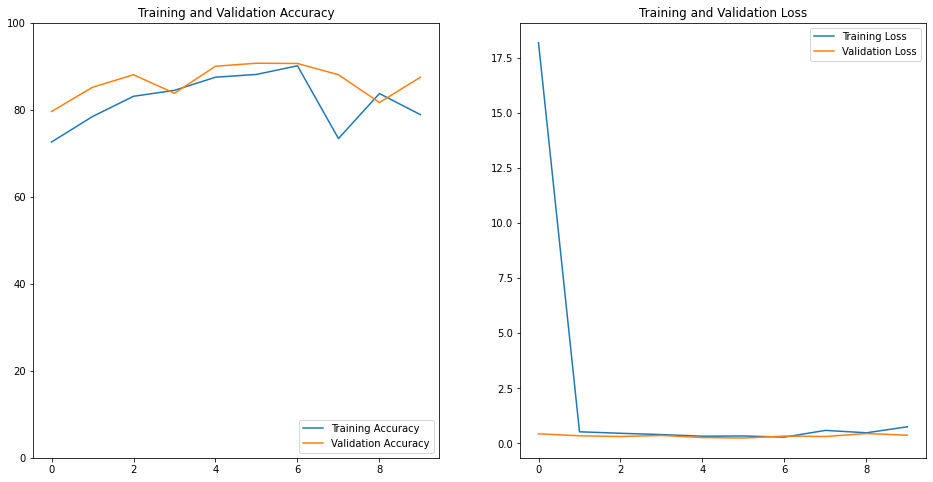

In [ ]:
epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_history, label='Training Accuracy')
plt.plot(epochs_range, val_acc_history, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim(0,100)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_history, label='Training Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.01,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

Epoch 5, Loss: 0.33, Accuracy: 88.15, Val Loss 0.24, Val Accuracy 90.73, Time: 53.2 secs

## Train a model from scratch

In [ ]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

In [ ]:
# a dataset that returns image paths
image_dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_dataset = image_dataset.map(
  load_and_preprocess_image, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [ ]:
# here's our final training dataset
train_path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_image_ds = train_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
my_train_ds = train_image_label_ds.cache()
my_train_ds = my_train_ds.shuffle(SHUFFLE_SIZE)
my_train_ds = my_train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_image_ds = test_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))
my_test_ds = test_image_label_ds.cache().batch(BATCH_SIZE)

In [ ]:
my_model = Sequential([
        Conv2D(32, kernel_size=(5, 5), input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ])
        

my_model.summary()

print('Number of trainable layers in the model:', len(my_model.trainable_weights))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 299, 299, 32)      2432      
                                                                 
 batch_normalization_98 (Bat  (None, 299, 299, 32)     128       
 chNormalization)                                                
                                                                 
 activation_98 (Activation)  (None, 299, 299, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_99 (Conv2D)          (None, 149, 149, 64)      18496     
                                                                 
 batch_normalization_99 (Bat  (None, 149, 149, 64)    

In [ ]:
from keras.optimizers import Adam
my_model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Utilities to help us record metrics.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

In [ ]:
# Code to evaluate on the validation dataset
def my_evaluate(ds, max_steps=None):
  steps = 0
  for activation_batch, answer_batch in ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = my_model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)

In [ ]:
my_train_loss_history, my_train_acc_history = [], []
my_val_loss_history, my_val_acc_history = [], []

epochs = 10 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for activation_batch, answer_batch in my_train_ds:
    result = my_model.train_on_batch(x=activation_batch, y=answer_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  my_evaluate(my_test_ds, max_steps=200)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  my_train_loss_history.append(train_loss.result())
  my_train_acc_history.append(train_accuracy.result() * 100)
  my_val_loss_history.append(val_loss.result())
  my_val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  # print("Saving weights")
  # model.save_weights(checkpoint_path.format(epoch=epoch,model='myModel'))

1/1 [==============================] - 0s 382ms/step
Epoch 0, Loss: 0.49, Accuracy: 79.72, Val Loss 0.40, Val Accuracy 82.56, Time: 133.5 secs
1/1 [==============================] - 0s 22ms/step
Epoch 1, Loss: 0.32, Accuracy: 87.25, Val Loss 0.38, Val Accuracy 84.05, Time: 20.3 secs
1/1 [==============================] - 0s 22ms/step
Epoch 2, Loss: 0.28, Accuracy: 89.19, Val Loss 0.27, Val Accuracy 89.18, Time: 20.4 secs
1/1 [==============================] - 0s 25ms/step
Epoch 3, Loss: 0.23, Accuracy: 90.83, Val Loss 0.27, Val Accuracy 89.35, Time: 20.2 secs
1/1 [==============================] - 0s 26ms/step
Epoch 4, Loss: 0.21, Accuracy: 92.10, Val Loss 0.28, Val Accuracy 88.72, Time: 20.2 secs
1/1 [==============================] - 0s 27ms/step
Epoch 5, Loss: 0.16, Accuracy: 93.31, Val Loss 0.37, Val Accuracy 88.03, Time: 20.3 secs
1/1 [==============================] - 0s 21ms/step
Epoch 6, Loss: 0.14, Accuracy: 94.40, Val Loss 0.29, Val Accuracy 89.93, Time: 21.4 secs
1/1 [======

### Plots of training and validation loss and accuracy

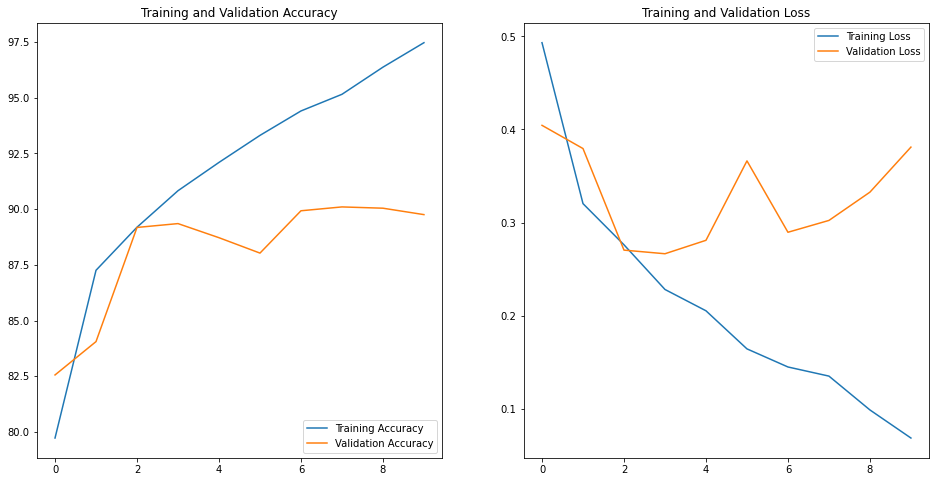

In [ ]:
epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, my_train_acc_history, label='Training Accuracy')
plt.plot(epochs_range, my_val_acc_history, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, my_train_loss_history, label='Training Loss')
plt.plot(epochs_range, my_val_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 7, Loss: 0.14, Accuracy: 95.15, Val Loss 0.30, Val Accuracy 90.10, Time: 20.5 secs
self-defined model has similar performance with the one with transfer learning
